## 1. Setup & Imports

In [3]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_log_error, mean_squared_error, mean_absolute_error,
    roc_auc_score, f1_score, precision_score, recall_score,
    precision_recall_curve, roc_curve, confusion_matrix
)
from sklearn.calibration import calibration_curve
import xgboost as xgb
from tqdm.auto import tqdm

import warnings
import gc
import os
import json
from pathlib import Path

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✓ Libraries loaded successfully")
print(f"  XGBoost: {xgb.__version__}")

✓ Libraries loaded successfully
  XGBoost: 3.1.1


e:\Datathon-FME\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

In [4]:
# === CONFIGURATION ===
CONFIG = {
    # Paths
    'data_path': './smadex-challenge-predict-the-revenue/train/train',
    'test_path': './smadex-challenge-predict-the-revenue/test/test',
    'output_dir': './outputs',
    'models_dir': './models_v2',
    
    # Data loading
    'sample_frac': 1.0,  # Usar 30% de datos para experimentación rápida
    'date_filters': [('datetime', '>=', '2025-10-01-00-00'), 
                     ('datetime', '<', '2025-10-02-00-00')],  # 1 día de datos
    
    # Target columns
    'target_buyer': 'buyer_d7',  # Binario: compra o no
    'target_revenue': 'iap_revenue_d7',  # Continuo: revenue
    
    # Features: Se detectarán AUTOMÁTICAMENTE del dataset
    'cat_features': 'auto',  # Detectar automáticamente
    'num_features': 'auto',  # Detectar automáticamente
    'exclude_features': ['row_id', 'datetime', 'buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28', 'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28'],  # No usar como features
    
    # Training
    'test_size': 0.2,
    'random_state': 42,
    'verbose': True
}

# Create output directories
Path(CONFIG['output_dir']).mkdir(exist_ok=True)
Path(CONFIG['models_dir']).mkdir(exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    if isinstance(v, (str, int, float, bool)):
        print(f"  {k}: {v}")

Configuration:
  data_path: ./smadex-challenge-predict-the-revenue/train/train
  test_path: ./smadex-challenge-predict-the-revenue/test/test
  output_dir: ./outputs
  models_dir: ./models_v2
  sample_frac: 1.0
  target_buyer: buyer_d7
  target_revenue: iap_revenue_d7
  cat_features: auto
  num_features: auto
  test_size: 0.2
  random_state: 42
  verbose: True


## 3. Data Loading & Minimal Preprocessing

In [17]:
# === LOAD DATA ===
def load_data(config):
    """
    Load data with minimal preprocessing.
    
    Strategy:
    - Load from parquet (fast)
    - Sample if needed (for quick experimentation)
    - NO complex transformations yet
    """
    print("="*80)
    print("LOADING DATA")
    print("="*80)
    
    # Load data with or without filters
    filters = config['date_filters'] if config.get('date_filters') else None
    if filters:
        print(f"Applying date filters: {filters}")
        ddf = dd.read_parquet(config['data_path'], filters=filters)
    else:
        print("Loading ALL available training data...")
        ddf = dd.read_parquet(config['data_path'])
    
    print(f"Total rows (estimated): {ddf.shape[0].compute():,}")
    
    # Sample for faster experimentation
    if config['sample_frac'] < 1.0:
        print(f"Sampling {config['sample_frac']*100:.0f}%...")
        ddf = ddf.sample(frac=config['sample_frac'], random_state=config['random_state'])
    else:
        print("Using 100% of data (PRODUCTION MODE)")
    
    df = ddf.compute()
    print(f"✓ Loaded: {len(df):,} rows, {len(df.columns)} columns")
    
    # Basic info
    if config['target_buyer'] in df.columns:
        buyer_rate = df[config['target_buyer']].mean()
        print(f"\nBuyer rate: {buyer_rate*100:.2f}% (imbalance: {(1-buyer_rate)/buyer_rate:.1f}:1)")
    
    if config['target_revenue'] in df.columns:
        revenue_stats = df[config['target_revenue']].describe()
        print(f"\nRevenue stats:")
        print(f"  Mean: ${revenue_stats['mean']:.2f}")
        print(f"  Max: ${revenue_stats['max']:.2f}")
        print(f"  Non-zero: {(df[config['target_revenue']] > 0).sum():,} ({(df[config['target_revenue']] > 0).mean()*100:.2f}%)")
    
    return df

df_raw = load_data(CONFIG)

LOADING DATA
Applying date filters: [('datetime', '>=', '2025-10-01-00-00'), ('datetime', '<', '2025-10-02-00-00')]
Total rows (estimated): 3,347,176
Using 100% of data (PRODUCTION MODE)
Total rows (estimated): 3,347,176
Using 100% of data (PRODUCTION MODE)
✓ Loaded: 3,347,176 rows, 85 columns

Buyer rate: 3.28% (imbalance: 29.5:1)

Revenue stats:
  Mean: $1.90
  Max: $696622.14
  Non-zero: 95,153 (2.84%)
✓ Loaded: 3,347,176 rows, 85 columns

Buyer rate: 3.28% (imbalance: 29.5:1)

Revenue stats:
  Mean: $1.90
  Max: $696622.14
  Non-zero: 95,153 (2.84%)


In [18]:
# === AUTOMATIC FEATURE DETECTION ===
def detect_feature_types(df, config):
    """
    Automatically detect categorical and numerical features.
    """
    print("\n" + "="*80)
    print("DETECTING FEATURE TYPES")
    print("="*80)
    
    exclude = set(config.get('exclude_features', []))
    exclude.add(config['target_buyer'])
    exclude.add(config['target_revenue'])
    
    cat_features = []
    num_features = []
    
    print(f"\nAnalyzing {len(df.columns)} columns...")
    for col in df.columns:
        if col in exclude:
            continue
        
        dtype = df[col].dtype
        
        try:
            if dtype == 'object' or 'string' in str(dtype).lower():
                # Check if it's actually hashable (not lists/dicts)
                sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
                if sample is not None and isinstance(sample, (str, int, float)):
                    cat_features.append(col)
            elif dtype in ['int64', 'int32', 'float64', 'float32']:
                # Exclude if too many unique values (likely row_id or similar)
                if df[col].nunique() < len(df) * 0.5:  # Less than 50% unique
                    num_features.append(col)
        except:
            # Skip columns that cause errors
            pass
    
    print(f"\nDetected Features:")
    print(f"  Categorical: {len(cat_features)} features")
    for col in cat_features:
        nunique = df[col].nunique()
        null_pct = df[col].isna().sum() / len(df) * 100
        print(f"    - {col:35s} | {nunique:6,} unique | {null_pct:5.1f}% null")
    
    print(f"\n  Numerical: {len(num_features)} features")
    for col in num_features:
        null_pct = df[col].isna().sum() / len(df) * 100
        mean_val = df[col].mean()
        print(f"    - {col:35s} | mean: {mean_val:10.4f} | {null_pct:5.1f}% null")
    
    return cat_features, num_features

# === MINIMAL PREPROCESSING WITH AUTOMATIC FEATURE DETECTION ===
def minimal_preprocessing(df, config):
    """
    Minimal preprocessing with automatic feature detection.
    """
    print("\n" + "="*80)
    print("MINIMAL PREPROCESSING")
    print("="*80)
    
    df = df.copy()
    
    # 1. Create buyer target if not exists
    if config['target_buyer'] not in df.columns:
        df[config['target_buyer']] = (df[config['target_revenue']] > 0).astype(int)
        print(f"Created {config['target_buyer']} from {config['target_revenue']}")
    
    # 2. Auto-detect features if not specified
    if config['cat_features'] == 'auto' or config['num_features'] == 'auto':
        cat_features, num_features = detect_feature_types(df, config)
        config['cat_features'] = cat_features
        config['num_features'] = num_features
    else:
        cat_features = [f for f in config['cat_features'] if f in df.columns]
        num_features = [f for f in config['num_features'] if f in df.columns]
    
    print(f"\n✓ Feature Detection Complete")
    print(f"  Using {len(cat_features) + len(num_features)} features")
    
    # 3. Simple encoding for categoricals
    encoders = {}
    for col in cat_features:
        df[col] = df[col].fillna('__MISSING__')
        df[col] = df[col].astype(str)
        unique_vals = df[col].unique()
        encoders[col] = {val: idx for idx, val in enumerate(unique_vals)}
        df[col] = df[col].map(encoders[col]).fillna(-1).astype(int)
    
    # 4. Handle NaNs in numerical features
    for col in num_features:
        df[col] = df[col].fillna(0)
    
    # 5. Prepare final feature matrix
    feature_cols = cat_features + num_features
    X = df[feature_cols].copy()
    y_buyer = df[config['target_buyer']].values
    y_revenue = df[config['target_revenue']].values
    
    print(f"\n✓ Preprocessing complete")
    print(f"  Features: {X.shape[1]} columns ({len(cat_features)} cat + {len(num_features)} num)")
    print(f"  Samples: {X.shape[0]:,}")
    print(f"  Buyer rate: {y_buyer.mean()*100:.2f}%")
    print(f"  Avg revenue (all): ${y_revenue.mean():.2f}")
    if (y_buyer == 1).sum() > 0:
        print(f"  Avg revenue (buyers only): ${y_revenue[y_buyer==1].mean():.2f}")
    
    return X, y_buyer, y_revenue, feature_cols, encoders

X, y_buyer, y_revenue, feature_cols, encoders = minimal_preprocessing(df_raw, CONFIG)

# Free memory
del df_raw
gc.collect()


MINIMAL PREPROCESSING



✓ Feature Detection Complete
  Using 31 features

✓ Preprocessing complete
  Features: 31 columns (14 cat + 17 num)
  Samples: 3,347,176
  Buyer rate: 3.28%

✓ Preprocessing complete
  Features: 31 columns (14 cat + 17 num)
  Samples: 3,347,176
  Buyer rate: 3.28%
  Avg revenue (all): $1.90
  Avg revenue (buyers only): $57.95
  Avg revenue (all): $1.90
  Avg revenue (buyers only): $57.95


0

In [19]:
# === TRAIN/TEST SPLIT ===
def create_splits(X, y_buyer, y_revenue, config):
    """
    Create train/test splits.
    
    Strategy:
    - Stratify by buyer_d7 to maintain class balance
    - Same split for both tasks
    """
    print("\n" + "="*80)
    print("CREATING TRAIN/TEST SPLITS")
    print("="*80)
    
    X_train, X_test, y_buyer_train, y_buyer_test, y_rev_train, y_rev_test = train_test_split(
        X, y_buyer, y_revenue,
        test_size=config['test_size'],
        random_state=config['random_state'],
        stratify=y_buyer  # CRITICAL: maintain class balance
    )
    
    print(f"Train: {len(X_train):,} samples ({y_buyer_train.mean()*100:.2f}% buyers)")
    print(f"Test:  {len(X_test):,} samples ({y_buyer_test.mean()*100:.2f}% buyers)")
    print(f"\nClass imbalance ratio (train): {(1-y_buyer_train.mean())/y_buyer_train.mean():.1f}:1")
    
    return X_train, X_test, y_buyer_train, y_buyer_test, y_rev_train, y_rev_test

X_train, X_test, y_buyer_train, y_buyer_test, y_rev_train, y_rev_test = create_splits(
    X, y_buyer, y_revenue, CONFIG
)


CREATING TRAIN/TEST SPLITS
Train: 2,677,740 samples (3.28% buyers)
Test:  669,436 samples (3.28% buyers)

Class imbalance ratio (train): 29.5:1
Train: 2,677,740 samples (3.28% buyers)
Test:  669,436 samples (3.28% buyers)

Class imbalance ratio (train): 29.5:1


## 4. Approach A: Two-Step Modeling (XGBoost)

**Strategy:**
1. **Classifier**: Predict buyer_d7 (with proper class weighting)
2. **Regressor**: Predict revenue ONLY for buyers
3. **Combine**: P(buyer) × E[revenue | buyer]

In [21]:
# === APPROACH A: TWO-STEP MODELING ===

def train_buyer_classifier_xgb(X_train, y_buyer_train, X_test, y_buyer_test, config):
    """
    Train XGBoost classifier for buyer prediction.
    
    IMPROVED: Better calibration and threshold optimization
    - scale_pos_weight: Automatic weighting based on class imbalance
    - Find optimal threshold based on F1 score
    - Better evaluation metrics for extreme imbalance
    """
    print("\n" + "="*80)
    print("TRAINING BUYER CLASSIFIER (XGBoost) - IMPROVED")
    print("="*80)
    
    # Calculate class weight
    n_neg = (y_buyer_train == 0).sum()
    n_pos = (y_buyer_train == 1).sum()
    scale_pos_weight = n_neg / n_pos
    
    print(f"\nClass imbalance handling:")
    print(f"  Negative samples: {n_neg:,}")
    print(f"  Positive samples: {n_pos:,}")
    print(f"  Buyer rate: {n_pos/(n_pos+n_neg)*100:.2f}%")
    print(f"  scale_pos_weight: {scale_pos_weight:.2f}")
    
    # IMPROVED: More conservative parameters for better calibration
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': scale_pos_weight,
        'max_depth': 5,  # Reduced from 6 for better generalization
        'learning_rate': 0.03,  # Slower learning for better calibration
        'n_estimators': 1000,  # More trees with early stopping
        'subsample': 0.7,  # More aggressive subsampling
        'colsample_bytree': 0.7,
        'min_child_weight': 5,  # Higher to prevent overfitting on minority class
        'gamma': 0.2,  # Higher regularization
        'reg_alpha': 0.1,  # L1 regularization
        'reg_lambda': 1.0,  # L2 regularization
        'random_state': config['random_state'],
        'tree_method': 'hist',
        'verbosity': 0,
        'early_stopping_rounds': 50  # FIXED: Now in constructor
    }
    
    clf = xgb.XGBClassifier(**params)
    
    # Train with early stopping (eval_set enables it)
    clf.fit(
        X_train, y_buyer_train,
        eval_set=[(X_test, y_buyer_test)],
        verbose=50 if config['verbose'] else False
    )
    
    # Get probabilities
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    # IMPROVED: Find optimal threshold based on F1 score
    print(f"\n=== Finding Optimal Threshold ===")
    thresholds = np.arange(0.05, 0.95, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_buyer_test, y_pred_binary)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    print(f"  Best threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
    print(f"  Default 0.5 threshold F1: {f1_score(y_buyer_test, (y_pred_proba >= 0.5).astype(int)):.4f}")
    
    # Use best threshold for evaluation
    y_pred_binary = (y_pred_proba >= best_threshold).astype(int)
    
    # Evaluation
    print(f"\n=== Classifier Performance (threshold={best_threshold:.2f}) ===")
    print(f"  AUC-ROC: {roc_auc_score(y_buyer_test, y_pred_proba):.4f}")
    print(f"  F1-Score: {f1_score(y_buyer_test, y_pred_binary):.4f}")
    print(f"  Precision: {precision_score(y_buyer_test, y_pred_binary):.4f}")
    print(f"  Recall: {recall_score(y_buyer_test, y_pred_binary):.4f}")
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_buyer_test, y_pred_binary).ravel()
    print(f"\n  Confusion Matrix:")
    print(f"    TN: {tn:,} | FP: {fp:,}")
    print(f"    FN: {fn:,} | TP: {tp:,}")
    print(f"    → Predicted {tp+fp} buyers, {tp} were correct ({tp/(tp+fp)*100 if tp+fp > 0 else 0:.1f}% precision)")
    print(f"    → Detected {tp}/{tp+fn} real buyers ({tp/(tp+fn)*100:.1f}% recall)")
    
    # CRITICAL: Check predicted buyer rate vs actual
    pred_buyer_rate = (y_pred_proba >= best_threshold).mean()
    actual_buyer_rate = y_buyer_test.mean()
    print(f"\n  Calibration check:")
    print(f"    Actual buyer rate: {actual_buyer_rate*100:.2f}%")
    print(f"    Predicted buyer rate (threshold={best_threshold:.2f}): {pred_buyer_rate*100:.2f}%")
    print(f"    Ratio: {pred_buyer_rate/actual_buyer_rate:.2f}x")
    
    # Store optimal threshold
    clf.best_threshold_ = best_threshold
    
    return clf, y_pred_proba

# Train XGBoost classifier
clf_xgb, buyer_proba_xgb = train_buyer_classifier_xgb(
    X_train, y_buyer_train, X_test, y_buyer_test, CONFIG
)


TRAINING BUYER CLASSIFIER (XGBoost) - IMPROVED

Class imbalance handling:
  Negative samples: 2,589,851
  Positive samples: 87,889
  Buyer rate: 3.28%
  scale_pos_weight: 29.47
[0]	validation_0-logloss:0.68045
[0]	validation_0-logloss:0.68045
[50]	validation_0-logloss:0.43056
[50]	validation_0-logloss:0.43056
[100]	validation_0-logloss:0.37636
[100]	validation_0-logloss:0.37636
[150]	validation_0-logloss:0.35569
[150]	validation_0-logloss:0.35569
[200]	validation_0-logloss:0.34502
[200]	validation_0-logloss:0.34502
[250]	validation_0-logloss:0.33762
[250]	validation_0-logloss:0.33762
[300]	validation_0-logloss:0.33153
[300]	validation_0-logloss:0.33153
[350]	validation_0-logloss:0.32669
[350]	validation_0-logloss:0.32669
[400]	validation_0-logloss:0.32280
[400]	validation_0-logloss:0.32280
[450]	validation_0-logloss:0.31996
[450]	validation_0-logloss:0.31996
[500]	validation_0-logloss:0.31721
[500]	validation_0-logloss:0.31721
[550]	validation_0-logloss:0.31496
[550]	validation_0-logl

In [22]:
def train_revenue_regressor_xgb(X_train, y_buyer_train, y_rev_train, X_test, y_buyer_test, y_rev_test, config):
    """
    Train XGBoost regressor for revenue prediction.
    
    Strategy:
    - Train ONLY on buyers (y_buyer == 1)
    - Use log1p transform (revenue is right-skewed)
    - Predict on full test set, but only evaluate on buyers
    """
    print("\n" + "="*80)
    print("TRAINING REVENUE REGRESSOR (XGBoost)")
    print("="*80)
    
    # Filter: train only on buyers
    mask_buyers_train = y_buyer_train == 1
    mask_buyers_test = y_buyer_test == 1
    
    X_train_buyers = X_train[mask_buyers_train]
    y_train_buyers = y_rev_train[mask_buyers_train]
    
    X_test_buyers = X_test[mask_buyers_test]
    y_test_buyers = y_rev_test[mask_buyers_test]
    
    print(f"Training on {len(X_train_buyers):,} buyers only")
    print(f"Revenue stats (train buyers):")
    print(f"  Mean: ${y_train_buyers.mean():.2f}")
    print(f"  Median: ${np.median(y_train_buyers):.2f}")
    print(f"  Max: ${y_train_buyers.max():.2f}")
    
    # Log transform (handle right-skewed revenue)
    y_train_buyers_log = np.log1p(y_train_buyers)
    y_test_buyers_log = np.log1p(y_test_buyers)
    
    # XGBoost regressor
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.05,
        'n_estimators': 500,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'gamma': 0.1,
        'random_state': config['random_state'],
        'tree_method': 'hist',
        'verbosity': 0,
        'early_stopping_rounds': 50  # Add early stopping
    }
    
    reg = xgb.XGBRegressor(**params)
    
    # Train with validation set for monitoring
    reg.fit(
        X_train_buyers, y_train_buyers_log,
        eval_set=[(X_test_buyers, y_test_buyers_log)],
        verbose=50 if config['verbose'] else False
    )
    
    # Predict on all test (but evaluate only on buyers)
    y_pred_log = reg.predict(X_test)
    y_pred_revenue = np.expm1(y_pred_log).clip(0, None)  # Inverse transform + clip negatives
    
    # Evaluate on buyers only
    y_pred_buyers = y_pred_revenue[mask_buyers_test]
    
    print(f"\n=== Regressor Performance (on buyers only) ===")
    print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_buyers, y_pred_buyers)):.2f}")
    print(f"  MAE: ${mean_absolute_error(y_test_buyers, y_pred_buyers):.2f}")
    
    # MSLE (only if no zeros in actual)
    if (y_test_buyers > 0).all():
        msle = mean_squared_log_error(y_test_buyers, y_pred_buyers)
        print(f"  MSLE: {msle:.4f}")
    
    return reg, y_pred_revenue

# Train XGBoost regressor
reg_xgb, revenue_pred_xgb = train_revenue_regressor_xgb(
    X_train, y_buyer_train, y_rev_train, X_test, y_buyer_test, y_rev_test, CONFIG
)


TRAINING REVENUE REGRESSOR (XGBoost)
Training on 87,889 buyers only
Revenue stats (train buyers):
  Mean: $65.10
  Median: $6.08
  Max: $696622.14
[0]	validation_0-rmse:1.42919
[50]	validation_0-rmse:0.99761
[50]	validation_0-rmse:0.99761
[100]	validation_0-rmse:0.96159
[100]	validation_0-rmse:0.96159
[150]	validation_0-rmse:0.94967
[150]	validation_0-rmse:0.94967
[200]	validation_0-rmse:0.94027
[200]	validation_0-rmse:0.94027
[250]	validation_0-rmse:0.93495
[250]	validation_0-rmse:0.93495
[300]	validation_0-rmse:0.93093
[300]	validation_0-rmse:0.93093
[350]	validation_0-rmse:0.92855
[350]	validation_0-rmse:0.92855
[400]	validation_0-rmse:0.92638
[400]	validation_0-rmse:0.92638
[450]	validation_0-rmse:0.92428
[450]	validation_0-rmse:0.92428
[499]	validation_0-rmse:0.92370
[499]	validation_0-rmse:0.92370

=== Regressor Performance (on buyers only) ===
  RMSE: $237.00
  MAE: $22.60

=== Regressor Performance (on buyers only) ===
  RMSE: $237.00
  MAE: $22.60


In [23]:
# === COMBINE TWO-STEP PREDICTIONS ===
def combine_two_step_predictions(buyer_proba, revenue_pred, y_buyer_test, y_rev_test):
    """
    Combine classifier and regressor predictions.
    
    Formula: predicted_revenue = P(buyer) × E[revenue | buyer]
    
    This accounts for:
    - Uncertainty in buyer prediction
    - Expected revenue given someone is a buyer
    """
    print("\n" + "="*80)
    print("COMBINING TWO-STEP PREDICTIONS")
    print("="*80)
    
    final_pred = buyer_proba * revenue_pred
    
    print(f"\nPrediction statistics:")
    print(f"  Buyer probability: {buyer_proba.mean():.4f} (avg)")
    print(f"  Revenue (if buyer): ${revenue_pred.mean():.2f} (avg)")
    print(f"  Final prediction: ${final_pred.mean():.2f} (avg)")
    
    print(f"\nPredicted zero revenue: {(final_pred < 0.01).sum():,} / {len(final_pred):,} ({(final_pred < 0.01).mean()*100:.1f}%)")
    print(f"Actual zero revenue: {(y_rev_test == 0).sum():,} / {len(y_rev_test):,} ({(y_rev_test == 0).mean()*100:.1f}%)")
    
    # Overall metrics
    print(f"\n=== Overall Performance ===")
    rmse = np.sqrt(mean_squared_error(y_rev_test, final_pred))
    mae = mean_absolute_error(y_rev_test, final_pred)
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE: ${mae:.2f}")
    
    # MSLE (if possible)
    try:
        # Add small epsilon to avoid log(0)
        msle = mean_squared_log_error(y_rev_test + 1e-6, final_pred + 1e-6)
        print(f"  MSLE: {msle:.4f}")
    except:
        print(f"  MSLE: N/A (contains zeros or negatives)")
    
    return final_pred

final_pred_xgb = combine_two_step_predictions(
    buyer_proba_xgb, revenue_pred_xgb, y_buyer_test, y_rev_test
)


COMBINING TWO-STEP PREDICTIONS

Prediction statistics:
  Buyer probability: 0.1994 (avg)
  Revenue (if buyer): $7.32 (avg)
  Final prediction: $2.32 (avg)

Predicted zero revenue: 167,499 / 669,436 (25.0%)
Actual zero revenue: 650,360 / 669,436 (97.2%)

=== Overall Performance ===
  RMSE: $43.79
  MAE: $2.70
  MSLE: 0.9103


## 5. Evaluation & Visualization


✓ Evaluation plots saved: ./outputs/evaluation_xgboost.png


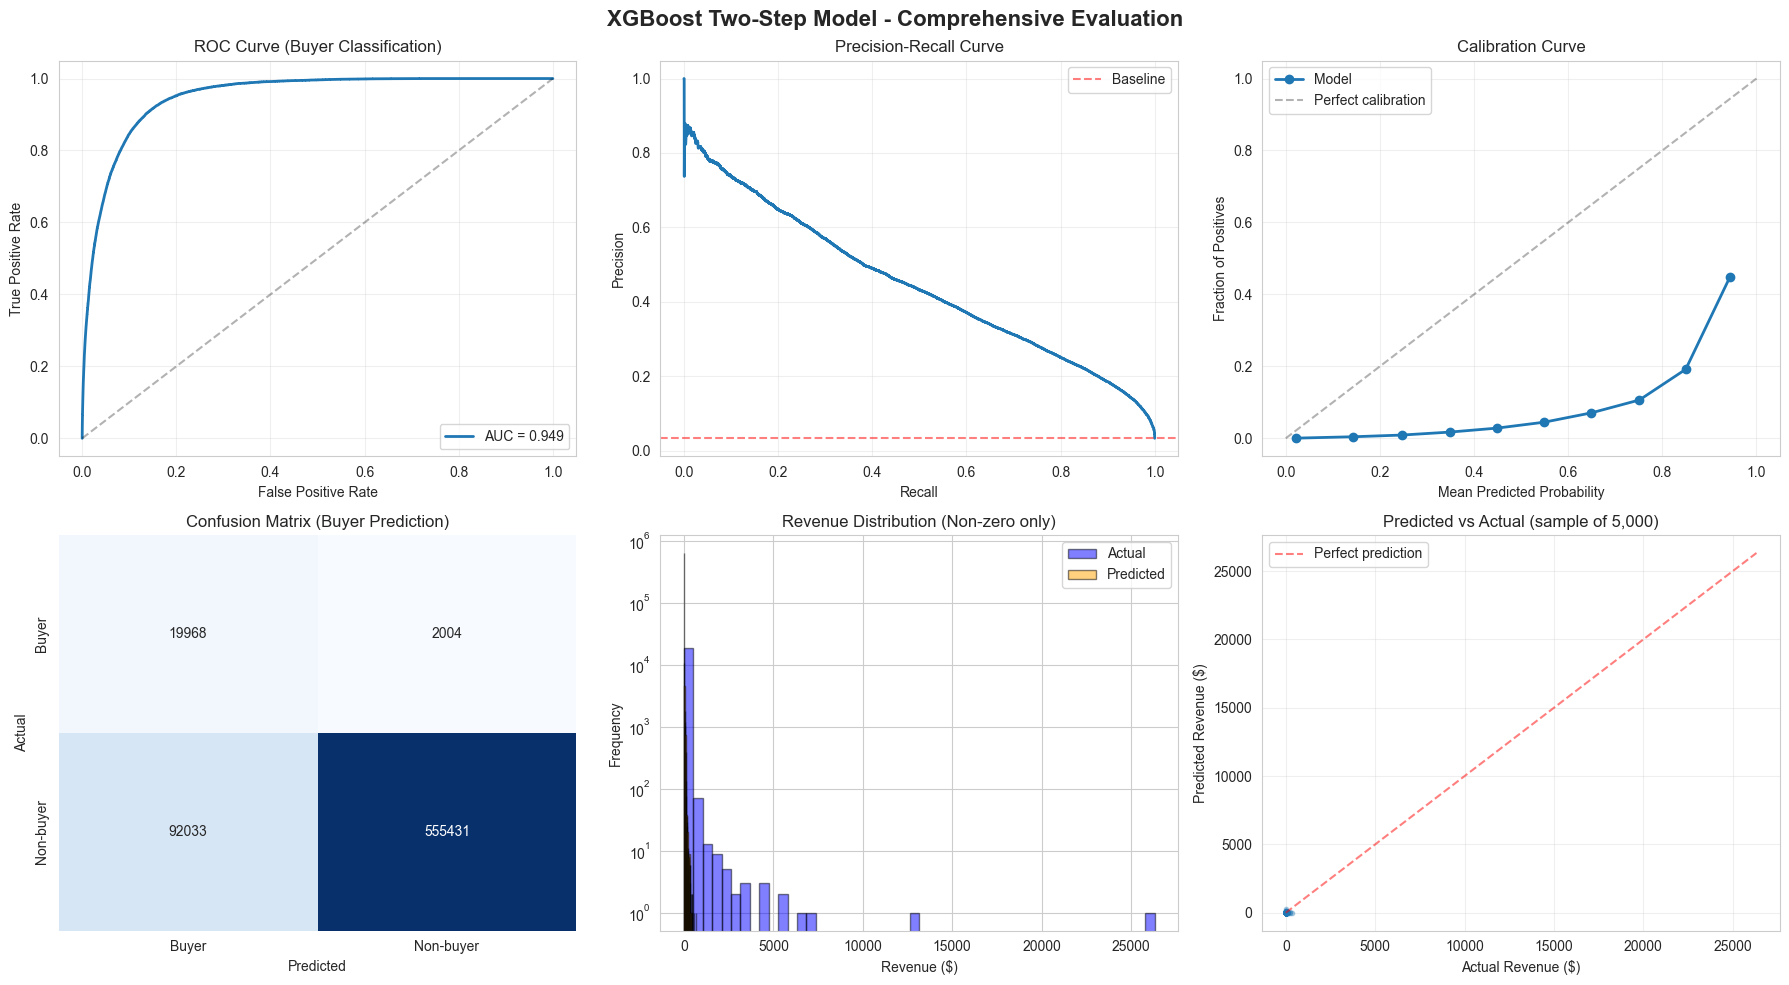

In [24]:
# === COMPREHENSIVE EVALUATION ===
def plot_evaluation(y_buyer_test, buyer_proba, y_rev_test, final_pred, approach_name="XGBoost"):
    """
    Comprehensive evaluation with multiple visualizations.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{approach_name} Two-Step Model - Comprehensive Evaluation', fontsize=16, fontweight='bold')
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_buyer_test, buyer_proba)
    auc_score = roc_auc_score(y_buyer_test, buyer_proba)
    axes[0, 0].plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', linewidth=2)
    axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve (Buyer Classification)')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_buyer_test, buyer_proba)
    axes[0, 1].plot(recall, precision, linewidth=2)
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].axhline(y=y_buyer_test.mean(), color='r', linestyle='--', alpha=0.5, label='Baseline')
    axes[0, 1].legend()
    
    # 3. Calibration Curve
    prob_true, prob_pred = calibration_curve(y_buyer_test, buyer_proba, n_bins=10)
    axes[0, 2].plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect calibration')
    axes[0, 2].set_xlabel('Mean Predicted Probability')
    axes[0, 2].set_ylabel('Fraction of Positives')
    axes[0, 2].set_title('Calibration Curve')
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
    
    # 4. Buyer Distribution (Predicted vs Actual)
    buyer_pred_binary = (buyer_proba >= 0.5).astype(int)
    df_comparison = pd.DataFrame({
        'Actual': ['Non-buyer', 'Buyer'] * 2,
        'Predicted': ['Non-buyer']*2 + ['Buyer']*2,
        'Count': [
            ((y_buyer_test == 0) & (buyer_pred_binary == 0)).sum(),
            ((y_buyer_test == 1) & (buyer_pred_binary == 0)).sum(),
            ((y_buyer_test == 0) & (buyer_pred_binary == 1)).sum(),
            ((y_buyer_test == 1) & (buyer_pred_binary == 1)).sum()
        ]
    })
    pivot = df_comparison.pivot(index='Actual', columns='Predicted', values='Count')
    sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], cbar=False)
    axes[1, 0].set_title('Confusion Matrix (Buyer Prediction)')
    
    # 5. Revenue Distribution
    axes[1, 1].hist(y_rev_test[y_rev_test > 0], bins=50, alpha=0.5, label='Actual', color='blue', edgecolor='black')
    axes[1, 1].hist(final_pred[final_pred > 0], bins=50, alpha=0.5, label='Predicted', color='orange', edgecolor='black')
    axes[1, 1].set_xlabel('Revenue ($)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Revenue Distribution (Non-zero only)')
    axes[1, 1].legend()
    axes[1, 1].set_yscale('log')
    
    # 6. Predicted vs Actual Revenue (scatter)
    sample_indices = np.random.choice(len(y_rev_test), min(5000, len(y_rev_test)), replace=False)
    axes[1, 2].scatter(y_rev_test[sample_indices], final_pred[sample_indices], alpha=0.3, s=10)
    axes[1, 2].plot([0, y_rev_test.max()], [0, y_rev_test.max()], 'r--', alpha=0.5, label='Perfect prediction')
    axes[1, 2].set_xlabel('Actual Revenue ($)')
    axes[1, 2].set_ylabel('Predicted Revenue ($)')
    axes[1, 2].set_title(f'Predicted vs Actual (sample of {len(sample_indices):,})')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{CONFIG["output_dir"]}/evaluation_{approach_name.lower()}.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Evaluation plots saved: {CONFIG['output_dir']}/evaluation_{approach_name.lower()}.png")
    plt.show()

plot_evaluation(y_buyer_test, buyer_proba_xgb, y_rev_test, final_pred_xgb, "XGBoost")

## 7. Save Models & Configuration

In [25]:
# === SAVE MODELS ===
def save_models(clf, reg, config, encoders, feature_cols):
    """
    Save trained models and metadata.
    """
    print("\n" + "="*80)
    print("SAVING XGBOOST MODELS")
    print("="*80)
    
    model_dir = Path(config['models_dir']) / 'xgboost'
    model_dir.mkdir(exist_ok=True, parents=True)
    
    # Save models
    clf.save_model(str(model_dir / 'classifier.json'))
    reg.save_model(str(model_dir / 'regressor.json'))
    
    # Save metadata
    metadata = {
        'approach': 'xgboost',
        'feature_cols': feature_cols,
        'encoders': {k: {str(vk): int(vv) for vk, vv in v.items()} for k, v in encoders.items()},
        'config': {
            'target_buyer': config['target_buyer'],
            'target_revenue': config['target_revenue'],
            'cat_features': config['cat_features'],
            'num_features': config['num_features']
        }
    }
    
    with open(model_dir / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✓ Models saved to: {model_dir}")
    print(f"  - classifier.json")
    print(f"  - regressor.json")
    print(f"  - metadata.json")

save_models(clf_xgb, reg_xgb, CONFIG, encoders, feature_cols)


SAVING XGBOOST MODELS
✓ Models saved to: models_v2\xgboost
  - classifier.json
  - regressor.json
  - metadata.json
✓ Models saved to: models_v2\xgboost
  - classifier.json
  - regressor.json
  - metadata.json


## 8. Summary & Next Steps

In [26]:
# === SUMMARY ===
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print("\n✓ Pipeline completed successfully!")
print("\nWhat was implemented:")
print("  1. Minimal preprocessing (label encoding, NaN handling)")
print("  2. Two-step modeling (Classifier → Regressor)")
print("  3. Proper imbalance handling (scale_pos_weight, stratified split)")
print("  4. XGBoost models with early stopping")
print("  5. Comprehensive evaluation (ROC, PR curve, calibration, etc.)")
print("  6. Modular, extensible code")

print("\nKey Results (XGBoost):")
print(f"  Buyer Classification AUC: {roc_auc_score(y_buyer_test, buyer_proba_xgb):.4f}")
print(f"  Revenue Prediction RMSE: ${np.sqrt(mean_squared_error(y_rev_test, final_pred_xgb)):.2f}")
print(f"  Revenue Prediction MAE: ${mean_absolute_error(y_rev_test, final_pred_xgb):.2f}")

print("\n📊 Next Steps:")
print("  1. Add more features (session counts, time-based, behavioral)")
print("  2. Feature engineering (interactions, aggregations)")
print("  3. Hyperparameter tuning (Optuna, GridSearch)")
print("  4. Try focal loss for classifier")
print("  5. Ensemble different models")
print("  6. Cross-validation for robust evaluation")
print("  7. Deploy inference pipeline")

print("\n" + "="*80)


SUMMARY

✓ Pipeline completed successfully!

What was implemented:
  1. Minimal preprocessing (label encoding, NaN handling)
  2. Two-step modeling (Classifier → Regressor)
  3. Proper imbalance handling (scale_pos_weight, stratified split)
  4. XGBoost models with early stopping
  5. Comprehensive evaluation (ROC, PR curve, calibration, etc.)
  6. Modular, extensible code

Key Results (XGBoost):
  Buyer Classification AUC: 0.9490
  Revenue Prediction RMSE: $43.79
  Revenue Prediction MAE: $2.70

📊 Next Steps:
  1. Add more features (session counts, time-based, behavioral)
  2. Feature engineering (interactions, aggregations)
  3. Hyperparameter tuning (Optuna, GridSearch)
  4. Try focal loss for classifier
  5. Ensemble different models
  6. Cross-validation for robust evaluation
  7. Deploy inference pipeline



## 9. Generate Predictions on Test Data

In [27]:
# === LOAD TRAINED MODELS (OPTIONAL - Skip if models already in memory) ===
"""
Esta celda es OPCIONAL y solo necesitas ejecutarla si:
- Acabas de abrir el notebook
- Reiniciaste el kernel
- Quieres usar modelos previamente entrenados

Si acabas de entrenar los modelos en este notebook, SALTA esta celda.
"""

# Verificar si los modelos ya están en memoria
if 'clf_xgb' not in locals() or 'reg_xgb' not in locals():
    print("="*80)
    print("LOADING SAVED MODELS")
    print("="*80)
    
    model_dir = Path(CONFIG['models_dir']) / 'xgboost'
    
    # Verificar que existan los archivos
    classifier_path = model_dir / 'classifier.json'
    regressor_path = model_dir / 'regressor.json'
    metadata_path = model_dir / 'metadata.json'
    
    if not classifier_path.exists() or not regressor_path.exists():
        print("❌ ERROR: Model files not found!")
        print("   Please run the training cells first (cells 6-16)")
        raise FileNotFoundError("Models not found. Train the models first.")
    
    print("\n✓ Loading models...")
    clf_xgb = xgb.XGBClassifier()
    clf_xgb.load_model(str(classifier_path))
    
    reg_xgb = xgb.XGBRegressor()
    reg_xgb.load_model(str(regressor_path))
    
    # Load metadata
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    feature_cols = metadata['feature_cols']
    encoders = metadata['encoders']
    
    # Convert encoder keys back to strings (they were saved as strings)
    encoders = {k: {str(vk): int(vv) for vk, vv in v.items()} for k, v in encoders.items()}
    
    # Update CONFIG with feature info
    CONFIG['cat_features'] = metadata['config']['cat_features']
    CONFIG['num_features'] = metadata['config']['num_features']
    
    print(f"✓ Models loaded successfully!")
    print(f"  Classifier: {classifier_path}")
    print(f"  Regressor: {regressor_path}")
    print(f"  Features: {len(feature_cols)} columns")
else:
    print("✓ Models already in memory (skipping load)")
    print("  If you want to load from disk, restart kernel and run this cell.")

✓ Models already in memory (skipping load)
  If you want to load from disk, restart kernel and run this cell.


In [28]:
# === LOAD & PREPARE TEST DATA ===
def load_and_prepare_test_data(config, encoders, feature_cols):
    """
    Load test data and apply same preprocessing as training data.
    OPTIMIZED: Only load columns we actually need!
    """
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)
    
    print(f"\nLoading test data from: {config['test_path']}")
    ddf_test = dd.read_parquet(config['test_path'])
    
    # Save row_ids for submission (only compute this column)
    print("  Computing row_ids...")
    test_row_ids = ddf_test["row_id"].compute()
    print(f"✓ Test set size: {len(test_row_ids):,} rows")
    
    # Optional: sample test data (for faster experimentation)
    if config.get('sample_frac', 1.0) < 1.0:
        print(f"  Sampling {config['sample_frac']*100:.0f}% of test data...")
        ddf_test = ddf_test.sample(frac=config['sample_frac'], random_state=config['random_state'])
        test_row_ids = ddf_test["row_id"].compute()
        print(f"✓ Sampled: {len(test_row_ids):,} rows")
    
    # OPTIMIZATION: Only load columns we need (feature_cols + categorical features)
    # This is much faster than loading all 85 columns!
    print("\n  Computing only required columns...")
    all_features = list(set(config['cat_features'] + config['num_features']))
    cols_to_load = [c for c in all_features if c in ddf_test.columns]
    print(f"    Loading {len(cols_to_load)} of {len(ddf_test.columns)} columns")
    
    # Progress bar for compute
    print("  Loading data with progress tracking...")
    df_test = ddf_test[cols_to_load].compute()
    print(f"✓ Test data loaded: {df_test.shape}")
    
    # Apply same preprocessing as training
    print("\nApplying preprocessing...")
    df_test = df_test.copy()
    
    # Categorical encoding (using same encoders from training) with progress bar
    print(f"  Encoding {len(config['cat_features'])} categorical features...")
    for col in tqdm(config['cat_features'], desc="Categorical encoding", leave=False):
        if col in df_test.columns:
            df_test[col] = df_test[col].fillna('__MISSING__').astype(str)
            # Map using training encoder, unknown values → -1
            df_test[col] = df_test[col].map(encoders[col]).fillna(-1).astype(int)
        else:
            df_test[col] = -1
    
    # Numerical features with progress bar
    print(f"  Filling {len(config['num_features'])} numerical features...")
    for col in tqdm(config['num_features'], desc="Numerical fillna", leave=False):
        if col not in df_test.columns:
            df_test[col] = 0.0
        df_test[col] = df_test[col].fillna(0)
    
    # Create X_test_final with correct column order (renamed to avoid conflict with validation X_test)
    X_test_final = df_test[feature_cols].copy()
    X_test_final = X_test_final.fillna(0)
    
    print(f"✓ Preprocessing complete")
    print(f"  Shape: {X_test_final.shape}")
    print(f"  Features: {X_test_final.shape[1]}")
    
    # Cleanup
    del ddf_test, df_test
    gc.collect()
    
    return X_test_final, test_row_ids

# Load test data (renamed to avoid conflict with validation set)
X_test_final, test_row_ids_final = load_and_prepare_test_data(CONFIG, encoders, feature_cols)


LOADING TEST DATA

Loading test data from: ./smadex-challenge-predict-the-revenue/test/test


  Computing row_ids...
✓ Test set size: 13,188,409 rows

  Computing only required columns...
    Loading 24 of 68 columns
  Loading data with progress tracking...
✓ Test set size: 13,188,409 rows

  Computing only required columns...
    Loading 24 of 68 columns
  Loading data with progress tracking...
✓ Test data loaded: (13188409, 24)

Applying preprocessing...
✓ Test data loaded: (13188409, 24)

Applying preprocessing...
  Encoding 14 categorical features...
  Encoding 14 categorical features...


  Filling 17 numerical features...


✓ Preprocessing complete
  Shape: (13188409, 31)
  Features: 31


In [29]:
# === GENERATE PREDICTIONS ===
def predict_on_test(clf, reg, X_test_final, use_optimal_threshold=True):
    """
    Generate two-step predictions on test data.
    
    IMPROVED: Uses optimal threshold found during training for better calibration
    
    Args:
        clf: Trained classifier
        reg: Trained regressor
        X_test_final: Test features
        use_optimal_threshold: If True, use the optimal threshold from training
    
    Returns:
        final_pred: Combined predictions (P(buyer) × E[revenue | buyer])
        buyer_proba: Buyer probabilities from classifier
        revenue_pred: Revenue predictions from regressor
    """
    print("\n" + "="*80)
    print("GENERATING TEST PREDICTIONS")
    print("="*80)
    
    # Get optimal threshold if available
    optimal_threshold = getattr(clf, 'best_threshold_', 0.5)
    
    # Stage 1: Predict buyer probability
    print("\nStage 1: Predicting buyer probability...")
    print("  Processing predictions with progress bar...")
    
    # Split into batches for progress tracking
    batch_size = 50000
    n_samples = len(X_test_final)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    buyer_proba = np.zeros(n_samples)
    
    for i in tqdm(range(n_batches), desc="Classifier predictions", unit="batch"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch = X_test_final.iloc[start_idx:end_idx]
        buyer_proba[start_idx:end_idx] = clf.predict_proba(batch)[:, 1]
    
    print(f"  Min: {buyer_proba.min():.6f}")
    print(f"  Max: {buyer_proba.max():.6f}")
    print(f"  Mean: {buyer_proba.mean():.6f}")
    print(f"  Median: {np.median(buyer_proba):.6f}")
    
    if use_optimal_threshold:
        print(f"\n  Using optimal threshold: {optimal_threshold:.2f}")
        print(f"  Predicted buyers (p>{optimal_threshold:.2f}): {(buyer_proba > optimal_threshold).sum():,} ({(buyer_proba > optimal_threshold).mean()*100:.2f}%)")
    else:
        print(f"  Predicted buyers (p>0.5): {(buyer_proba > 0.5).sum():,} ({(buyer_proba > 0.5).mean()*100:.2f}%)")
    
    # Stage 2: Predict revenue (in log space)
    print("\nStage 2: Predicting revenue...")
    print("  Processing predictions with progress bar...")
    
    revenue_pred = np.zeros(n_samples)
    
    for i in tqdm(range(n_batches), desc="Regressor predictions", unit="batch"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch = X_test_final.iloc[start_idx:end_idx]
        revenue_log = reg.predict(batch)
        revenue_pred[start_idx:end_idx] = np.expm1(revenue_log).clip(0, None)
    
    print(f"  Min: ${revenue_pred.min():.2f}")
    print(f"  Max: ${revenue_pred.max():.2f}")
    print(f"  Mean: ${revenue_pred.mean():.2f}")
    print(f"  Median: ${np.median(revenue_pred):.2f}")
    
    # Stage 3: Combine with SMART THRESHOLDING
    print("\nStage 3: Combining predictions with optimal threshold...")
    
    if use_optimal_threshold:
        # Use optimal threshold: set to 0 if buyer_proba < threshold
        final_pred = buyer_proba * revenue_pred
        mask_zero = buyer_proba < optimal_threshold
        final_pred[mask_zero] = 0.0
        
        print(f"  Strategy: Using P(buyer)>{optimal_threshold:.2f} as cutoff")
        print(f"  → Only predictions above {optimal_threshold:.2f} kept as non-zero")
        print(f"  → This matches the F1-optimized classification threshold")
    else:
        # Raw combination without thresholding
        final_pred = buyer_proba * revenue_pred
        print(f"  Strategy: Raw P(buyer) × E[revenue]")
    
    print(f"\n  Final predictions:")
    print(f"    Exact zeros: {(final_pred == 0).sum():,} ({(final_pred == 0).mean()*100:.1f}%)")
    print(f"    Non-zeros: {(final_pred > 0).sum():,} ({(final_pred > 0).mean()*100:.1f}%)")
    print(f"    Min: ${final_pred.min():.6f}")
    print(f"    Max: ${final_pred.max():.2f}")
    print(f"    Mean: ${final_pred.mean():.4f}")
    print(f"    Median: ${np.median(final_pred):.4f}")
    
    if (final_pred > 0).sum() > 0:
        print(f"\n  Non-zero statistics:")
        nz_pred = final_pred[final_pred > 0]
        print(f"    Min: ${nz_pred.min():.4f}")
        print(f"    Mean: ${nz_pred.mean():.2f}")
        print(f"    Median: ${np.median(nz_pred):.2f}")
        print(f"    Max: ${nz_pred.max():.2f}")
    
    return final_pred, buyer_proba, revenue_pred

# Generate predictions on test data
print("="*80)
print("PREDICTION STRATEGY - IMPROVED")
print("="*80)
print("\nUsing OPTIMAL THRESHOLD from training:")
print("  - Threshold encontrado mediante maximización de F1-score")
print("  - Mejor balance entre precision y recall")
print("  - Calibración más realista que threshold fijo")
print("="*80)

final_pred_test, buyer_proba_test, revenue_pred_test = predict_on_test(
    clf_xgb, reg_xgb, X_test_final, 
    use_optimal_threshold=True
)

PREDICTION STRATEGY - IMPROVED

Using OPTIMAL THRESHOLD from training:
  - Threshold encontrado mediante maximización de F1-score
  - Mejor balance entre precision y recall
  - Calibración más realista que threshold fijo

GENERATING TEST PREDICTIONS

Stage 1: Predicting buyer probability...
  Processing predictions with progress bar...


Classifier predictions:   2%|▏         | 5/264 [00:00<00:30,  8.37batch/s]

Classifier predictions: 100%|██████████| 264/264 [00:30<00:00,  8.55batch/s]


  Min: 0.000116
  Max: 0.995256
  Mean: 0.126805
  Median: 0.033768

  Using optimal threshold: 0.90
  Predicted buyers (p>0.90): 63,231 (0.48%)

Stage 2: Predicting revenue...
  Processing predictions with progress bar...
  Predicted buyers (p>0.90): 63,231 (0.48%)

Stage 2: Predicting revenue...
  Processing predictions with progress bar...


Regressor predictions: 100%|██████████| 264/264 [00:20<00:00, 13.06batch/s]



  Min: $0.00
  Max: $925.01
  Mean: $6.77
  Median: $2.68

Stage 3: Combining predictions with optimal threshold...
  Strategy: Using P(buyer)>0.90 as cutoff
  → Only predictions above 0.90 kept as non-zero
  → This matches the F1-optimized classification threshold

  Final predictions:
    Exact zeros: 13,125,516 (99.5%)
    Non-zeros: 62,893 (0.5%)
    Min: $0.000000
    Max: $468.64
    Mean: $0.0923
    Median: $0.0000

  Non-zero statistics:
    Min: $0.0001
    Mean: $19.35
    Median: $11.19
    Max: $468.64
    Exact zeros: 13,125,516 (99.5%)
    Non-zeros: 62,893 (0.5%)
    Min: $0.000000
    Max: $468.64
    Mean: $0.0923
    Median: $0.0000

  Non-zero statistics:
    Min: $0.0001
    Mean: $19.35
    Median: $11.19
    Max: $468.64


In [30]:
# === SAVE SUBMISSION ===
def save_submission(final_pred, test_row_ids, config):
    """
    Save predictions to CSV file for submission.
    """
    print("\n" + "="*80)
    print("SAVING SUBMISSION")
    print("="*80)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        "row_id": test_row_ids.values,
        "iap_revenue_d7": final_pred
    })
    
    # Save to CSV
    output_path = os.path.join(config['output_dir'], "submission_xgboost.csv")
    os.makedirs(config['output_dir'], exist_ok=True)
    submission_df.to_csv(output_path, index=False)
    
    print(f"\n✓ Submission saved: {output_path}")
    print(f"  Shape: {submission_df.shape}")
    print(f"  Columns: {submission_df.columns.tolist()}")
    
    # Quick stats
    print(f"\n  Submission statistics:")
    print(f"    Min: ${submission_df['iap_revenue_d7'].min():.8f}")
    print(f"    Max: ${submission_df['iap_revenue_d7'].max():.2f}")
    print(f"    Mean: ${submission_df['iap_revenue_d7'].mean():.4f}")
    print(f"    Median: ${submission_df['iap_revenue_d7'].median():.4f}")
    
    print(f"\n  First 10 rows:")
    print(submission_df.head(10).to_string(index=False))
    
    return submission_df

# Save submission file (using renamed variables to avoid conflict)
submission_df = save_submission(final_pred_test, test_row_ids_final, CONFIG)


SAVING SUBMISSION

✓ Submission saved: ./outputs\submission_xgboost.csv
  Shape: (13188409, 2)
  Columns: ['row_id', 'iap_revenue_d7']

  Submission statistics:
    Min: $0.00000000
    Max: $468.64
    Mean: $0.0923
    Median: $0.0000

  First 10 rows:
                              row_id  iap_revenue_d7
e2f514a9-d922-4a17-bf94-f228bf4cd82f             0.0
4bfc70d3-d619-410a-9683-4cd759f30f32             0.0
ad433b66-b41e-4157-a6fd-24cd30701f6a             0.0
5ed964d6-ddce-42e8-9fad-276eb7f64c2f             0.0
81b73a45-c395-4d08-a4a3-513873440db3             0.0
22c09d3c-037d-4733-be84-764b0beea8ef             0.0
c991d87f-acee-40f5-9159-c2b9edd3c3ed             0.0
2ab1e530-3dd4-4a36-a33a-d9fe1b934b60             0.0
21fcdadc-5c27-4e31-8edf-1d84f93517ef             0.0
8131e176-c2fe-41b1-99da-771096ce48f1             0.0

✓ Submission saved: ./outputs\submission_xgboost.csv
  Shape: (13188409, 2)
  Columns: ['row_id', 'iap_revenue_d7']

  Submission statistics:
    Min: $0.000000

## 10. Visualization of Test Predictions

In [31]:
# === TEST PREDICTIONS ANALYSIS ===
print("\n" + "="*80)
print("TEST PREDICTIONS ANALYSIS")
print("="*80)

revenue = submission_df['iap_revenue_d7'].values

# Summary statistics
print(f"\nSummary Statistics:")
print(f"  Total predictions: {len(revenue):,}")
print(f"  Min: ${revenue.min():.8e}")
print(f"  Max: ${revenue.max():.2f}")
print(f"  Mean: ${revenue.mean():.4f}")
print(f"  Median: ${np.median(revenue):.4f}")
print(f"  Std Dev: ${revenue.std():.4f}")

# Percentiles
print(f"\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(revenue, p)
    print(f"  P{p:2d}: ${val:.4f}")

# Zero vs non-zero breakdown
zeros = (revenue < 0.01).sum()
non_zeros = (revenue >= 0.01).sum()
print(f"\n" + "="*80)
print("PREDICTION BREAKDOWN (NEAR-ZERO vs NON-ZERO)")
print("="*80)
print(f"\n{'Near-zero (<$0.01):':<30} {zeros:>10,} samples ({zeros/len(revenue)*100:>6.1f}%)")
print(f"{'Non-zero (≥$0.01):':<30} {non_zeros:>10,} samples ({non_zeros/len(revenue)*100:>6.1f}%)")
print(f"{'Total:':<30} {len(revenue):>10,} samples")

if non_zeros > 0:
    print(f"{'Ratio (near-zero:non-zero):':<30} {zeros/non_zeros:>10.1f}:1")

# Revenue tiers
print(f"\nRevenue Distribution by Tier:")
tiers = [
    (0, 0.01, "$0 - $0.01"),
    (0.01, 1.0, "$0.01 - $1"),
    (1.0, 10.0, "$1 - $10"),
    (10.0, 100.0, "$10 - $100"),
    (100.0, float('inf'), "$100+")
]

for min_val, max_val, label in tiers:
    mask = (revenue >= min_val) & (revenue < max_val)
    count = mask.sum()
    pct = count / len(revenue) * 100
    total_rev = revenue[mask].sum()
    print(f"  {label:15s}: {count:>10,} ({pct:>5.1f}%) → Total: ${total_rev:>12,.2f}")

# Non-zero statistics
if non_zeros > 0:
    revenue_nz = revenue[revenue >= 0.01]
    print(f"\n" + "="*80)
    print("NON-ZERO PREDICTIONS STATISTICS")
    print("="*80)
    print(f"  Count: {len(revenue_nz):,}")
    print(f"  Min: ${revenue_nz.min():.4f}")
    print(f"  Max: ${revenue_nz.max():.2f}")
    print(f"  Mean: ${revenue_nz.mean():.2f}")
    print(f"  Median: ${np.median(revenue_nz):.2f}")
    print(f"  Total revenue: ${revenue_nz.sum():,.2f}")


TEST PREDICTIONS ANALYSIS

Summary Statistics:
  Total predictions: 13,188,409
  Min: $0.00000000e+00
  Max: $468.64
  Mean: $0.0923
  Median: $0.0000
  Std Dev: $1.8689

Percentiles:
  P 1: $0.0000
  P 5: $0.0000
  P10: $0.0000
  P25: $0.0000
  P50: $0.0000
  P 5: $0.0000
  P10: $0.0000
  P25: $0.0000
  P50: $0.0000
  P75: $0.0000
  P90: $0.0000
  P95: $0.0000
  P99: $0.0000
  P75: $0.0000
  P90: $0.0000
  P95: $0.0000
  P99: $0.0000

PREDICTION BREAKDOWN (NEAR-ZERO vs NON-ZERO)

Near-zero (<$0.01):            13,125,552 samples (  99.5%)
Non-zero (≥$0.01):                 62,857 samples (   0.5%)
Total:                         13,188,409 samples
Ratio (near-zero:non-zero):         208.8:1

Revenue Distribution by Tier:

PREDICTION BREAKDOWN (NEAR-ZERO vs NON-ZERO)

Near-zero (<$0.01):            13,125,552 samples (  99.5%)
Non-zero (≥$0.01):                 62,857 samples (   0.5%)
Total:                         13,188,409 samples
Ratio (near-zero:non-zero):         208.8:1

Revenu


✓ Visualization saved: ./outputs\test_predictions_analysis.png


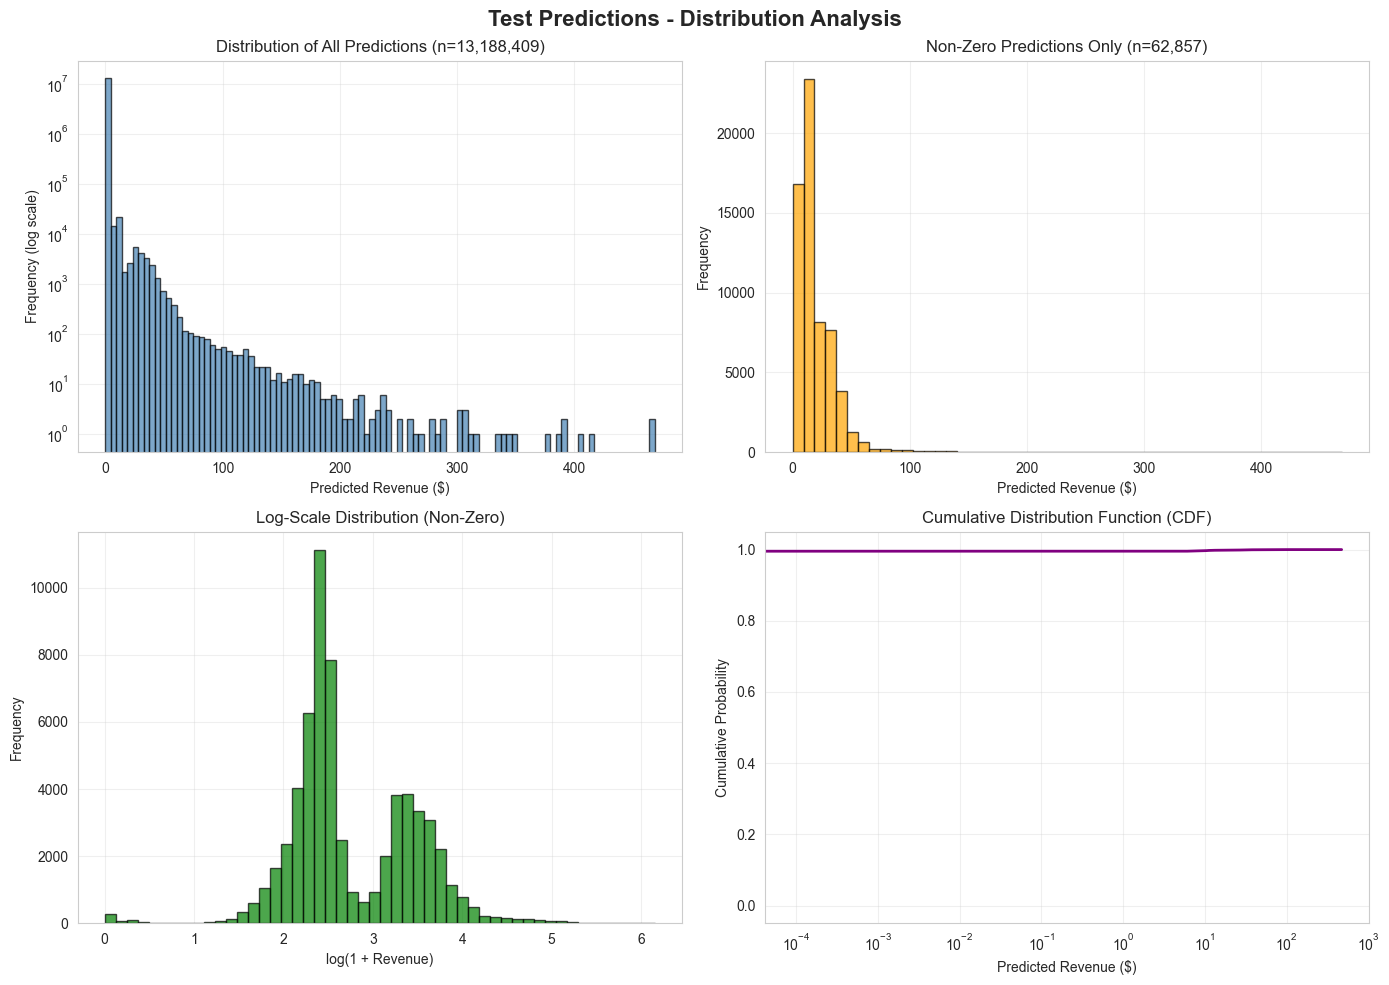


✓ TEST PREDICTIONS COMPLETE!

Files generated:
  1. ./outputs/submission_xgboost.csv
  2. ./outputs/test_predictions_analysis.png

✓ Ready for submission!


In [32]:
# === VISUALIZATION ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Test Predictions - Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Histogram of all predictions
axes[0, 0].hist(revenue, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Predicted Revenue ($)')
axes[0, 0].set_ylabel('Frequency (log scale)')
axes[0, 0].set_title(f'Distribution of All Predictions (n={len(revenue):,})')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_yscale('log')

# 2. Histogram of non-zero predictions only
non_zero_mask = revenue >= 0.01
if non_zero_mask.sum() > 0:
    revenue_nz = revenue[non_zero_mask]
    axes[0, 1].hist(revenue_nz, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('Predicted Revenue ($)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'Non-Zero Predictions Only (n={len(revenue_nz):,})')
    axes[0, 1].grid(alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No non-zero predictions', 
                    ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Non-Zero Predictions Only')

# 3. Log-scale histogram (non-zero)
if non_zero_mask.sum() > 0:
    axes[1, 0].hist(np.log1p(revenue_nz), bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].set_xlabel('log(1 + Revenue)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Log-Scale Distribution (Non-Zero)')
    axes[1, 0].grid(alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No non-zero predictions', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Log-Scale Distribution (Non-Zero)')

# 4. Cumulative Distribution Function (CDF)
sorted_rev = np.sort(revenue)
cumulative = np.arange(1, len(sorted_rev) + 1) / len(sorted_rev)
axes[1, 1].plot(sorted_rev, cumulative, linewidth=2, color='purple')
axes[1, 1].set_xlabel('Predicted Revenue ($)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Cumulative Distribution Function (CDF)')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xscale('log')

plt.tight_layout()
output_plot_path = os.path.join(CONFIG['output_dir'], 'test_predictions_analysis.png')
plt.savefig(output_plot_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Visualization saved: {output_plot_path}")
plt.show()

print("\n" + "="*80)
print("✓ TEST PREDICTIONS COMPLETE!")
print("="*80)
print(f"\nFiles generated:")
print(f"  1. {CONFIG['output_dir']}/submission_xgboost.csv")
print(f"  2. {CONFIG['output_dir']}/test_predictions_analysis.png")
print(f"\n✓ Ready for submission!")